<a href="https://colab.research.google.com/github/richardtml/riiaa-20-aa/blob/master/notebooks/3a_auto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje autosupervisado basado en rotaciones

#### Bere & Ricardo Montalvo Lezama

En esta libreta implementaremos un ejemplo de aprendizaje autosupervisado donde la tarea pretexto consiste en aprender la rotación de la imagen de entrada del conjunto CIFAR-10. Este ejemplo se basa en el artículo *Unsupervised Representation Learning by Predicting Image Rotations* de Gidaris et al. El objetivo es estudiar el aprendizaje autosupervisado y su potencial beneficio en el entrenamiento.

![RotNet](https://raw.githubusercontent.com/richardtml/riiaa-20-aa/master/media/rotnet.jpg)

# Explorando una tarea pretexto

En este ejemplo realizaremos clasificación del conjunto CIFAR-10. Contamos 3 subconjuntos: preentrenamiento con 50000 imágenes no etiquetadas, entrenamiento 5000 imágenes etiquetadas y prueba con 5000 imágenes etiquetadas

Se entrenaran dos clasificadores con el subconjunto de entrenamiento y se evaluaran en el subconjunto de prueba. Sin embargo, uno de estos clasificadores se preentrenará de forma autosupervisada para predecir la rotación de la imagen en el subconjunto de preentrenamiento

La siguiente tabla muestra los resultados de estos dos clasificadores y un clasificador entrenados empleando las 50k etiquetas del conjunto original.

| Entrenamiento        | Preentrenamiento | Entrenamiento | Prueba | Exactitud |
|----------------------|------------------|---------------|--------|-----------|
| Aleatorio            | NA               | NA            | NA     | 10.00     |
| Supervisado          | NA               | 5000          | 5000   | 52.48     |
| Auto+Super           | 50000            | 5000          | 5000   | 59.39     |
| Supervisado Completo | NA               | 50000         | 5000   | 68.50     |

## 1 Preparación

### 1.1 Bibliotecas

In [1]:
import random
from itertools import islice as take
from random import randint

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
from skimage import io
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
from tqdm import tqdm
from PIL import Image

DATA_DIR = '../data'

# CIFAR-10
MEAN = (0.4914, 0.4822, 0.4465)
STD = (0.2023, 0.1994, 0.2010)
LABELS = (
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)
BATCH_SIZE = 128

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

## 2 Datos

### 2.1 Exploración

In [2]:
# creamos un Dataset
ds = CIFAR10(root=DATA_DIR, train=True, transform=np.array, download=True)
# creamos un DataLoader
dl = DataLoader(ds, batch_size=12)

Files already downloaded and verified


x shape=torch.Size([12, 32, 32, 3]) dtype=torch.uint8
y shape=torch.Size([12]) dtype=torch.int64
tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7])
['frog', 'truck', 'truck', 'deer', 'automobile', 'automobile', 'bird', 'horse', 'ship', 'cat', 'deer', 'horse']


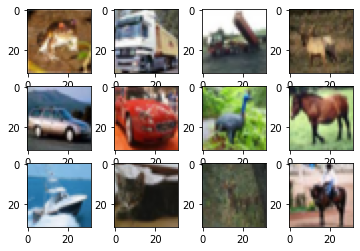

In [3]:
# desplegamos un lote de imágenes
for x, y in take(dl, 1):
    # imprimimos la forma y tipo de los tensores
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')
    # desplegamos imagenes
    io.imshow_collection(x)
    # imprimimos etiquetas
    print(y)
    print([LABELS[l] for l in y])

### 2.2 Subconjunto de preentrenamiento

In [4]:
class CIFAR10Rot(CIFAR10):
    
    def random_rotate(self, x):
        r = randint(0, 4)
        if r == 0:
            return x, 0
        elif r == 1:
            return np.flipud(np.transpose(x, (1, 0, 2))), 1
        elif r == 2:
            return np.flipud(np.fliplr(x)), 2
        else:
            return np.fliplr(np.transpose(x, (1, 0, 2))), 3
    
    def __getitem__(self, index):
        # leemos la imagen
        img = self.data[index]
        # la rotamos
        img, target = self.random_rotate(img)
        # la convertimos a pillow
        img = Image.fromarray(img)
        # aplicamos transformación si es necesario
        if self.transform is not None:
            img = self.transform(img)
        
        return img, target

In [5]:
# creamos un Dataset
ds = CIFAR10Rot(root=DATA_DIR, train=True, transform=np.array)
print(len(ds))

50000


x shape=torch.Size([12, 32, 32, 3]) dtype=torch.uint8
y shape=torch.Size([12]) dtype=torch.int64


<Figure size 720x720 with 0 Axes>

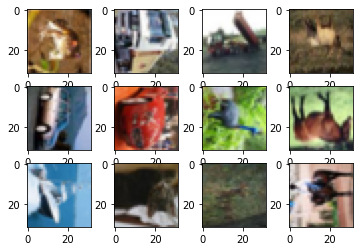

tensor([3, 3, 0, 2, 3, 3, 3, 2, 3, 2, 3, 1])
tensor([270, 270,   0, 180, 270, 270, 270, 180, 270, 180, 270,  90])


In [6]:
# creamos un DataLoader
dl = DataLoader(ds, batch_size=12)
# desplegamos un lote de imágenes
for x, y in take(dl, 1):
    # imprimimos la forma y tipo de los tensores
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')
    # desplegamos imagenes
    plt.figure(figsize=(10,10))
    io.imshow_collection(x)
    plt.show()
    # imprimimos etiquetas
    print(y)
    print(y * 90)

In [7]:
tsfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

pre_ds = CIFAR10Rot(
    root=DATA_DIR,
    train=True,
    transform=tsfm
)

pre_dl = DataLoader(
    pre_ds, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

print(len(pre_ds))

50000


### 2.3 Subconjuntos de entrenamiento y prueba

In [8]:
class MiniCIFAR10(CIFAR10):
    
    def __init__(self, root, train, transform, download=False, train_size=5000):
        super(MiniCIFAR10, self).__init__(root=root, 
                                          train=False, 
                                          transform=transform, 
                                          download=download)
        if train:
            self.data = self.data[:train_size]
            self.targets = self.targets[:train_size]
        else:
            self.data = self.data[train_size:]
            self.targets = self.targets[train_size:]

#### Entrenamiento

In [9]:
trn_ds = MiniCIFAR10(
    root=DATA_DIR,
    train=True,
    transform=tsfm
)
trn_dl = DataLoader(
    trn_ds, 
    batch_size=BATCH_SIZE,
    shuffle=True
)
print(len(trn_ds))

5000


In [10]:
for x, y in take(trn_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([128, 3, 32, 32]) dtype=torch.float32
y shape=torch.Size([128]) dtype=torch.int64


#### Prueba

In [11]:
tst_ds = MiniCIFAR10(
    root=DATA_DIR,
    train=False,
    transform=tsfm
)
tst_dl = DataLoader(
    tst_ds,
    batch_size=BATCH_SIZE
)
print(len(tst_ds))

5000


In [12]:
for x, y in take(tst_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([128, 3, 32, 32]) dtype=torch.float32
y shape=torch.Size([128]) dtype=torch.int64


## 3 Modelo

In [13]:
class CNN(nn.Module):

    def __init__(self, output_size):
        super(CNN, self).__init__()
        C1, C2, C3 = 8, 16, 32
        self.num_feats = 32 * 4 * 4
        self.cnn = nn.Sequential(
            # conv1
            # [N, 3, 32, 32] => [N, 8, 32, 32]
            nn.Conv2d(in_channels=3, out_channels=C1, kernel_size=3, padding=1),
            # [N, 8, 32, 32]
            nn.ReLU(),
            # [N, 8, 32, 32] => [N, 8, 16, 16]
            nn.MaxPool2d(kernel_size=2, stride=2),
            # [N, 8, 16, 16]
            nn.BatchNorm2d(C1),
            # conv2
            # [N, 8, 16, 16] => [N, 16, 16, 16]
            nn.Conv2d(in_channels=C1, out_channels=C2, kernel_size=3, padding=1),
            # [N, 16, 16, 16]
            nn.ReLU(),
            # [N, 16, 16, 16] => [N, 16, 8, 8]
            nn.MaxPool2d(kernel_size=2, stride=2),
            # [N, 16, 8, 8]
            nn.BatchNorm2d(C2),
            # conv3
            # [N, 16, 8, 8] => [N, 32, 8, 8]
            nn.Conv2d(in_channels=C2, out_channels=C3, kernel_size=3, padding=1),
            # [N, 32, 16, 16]
            nn.ReLU(),
            # [N, 32, 8, 8] => [N, 32, 4, 4]
            nn.MaxPool2d(kernel_size=2, stride=2),
            # [N, 32, 4, 4]
            nn.BatchNorm2d(C3)
        )
        # [N, 32, 4, 4] => [N, 32x4x4]
        self.flatten = nn.Flatten()
        # [N, 32x4x4] => [N, 4]
        self.cls = self.fc = nn.Linear(self.num_feats, output_size)

    def forward(self, x):
        # [N, 3, 32, 32] => [N, 16, 8, 8]
        x = self.cnn(x)
        # [N, 32, 4, 4] => [N, 32x4x4]
        x = self.flatten(x)
        # [N, 32x4x4] => [N, 4]
        x = self.cls(x)
        return x

In [14]:
model = CNN(10)
print(model)

CNN(
  (cnn): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (flatten): Flatten()
  (cls): Linear(in_features=512, out_features=10, bias=True)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)


In [15]:
# inferencia con datos sinteticos
x = torch.zeros(1, 3, 32, 32)
y = model(x)
print(y.shape)

torch.Size([1, 10])


In [16]:
model = CNN(4)
# inferencia con datos sinteticos
x = torch.zeros(1, 3, 32, 32)
y = model(x)
print(y.shape)

torch.Size([1, 4])


## 4 Entrenamiento

In [17]:
def fit(model, trn_dl, tst_dl, epochs=15, stop=None):
    # optimizador
    opt = optim.Adam(model.parameters(), lr=0.001)

    # mejor exactitud
    best_acc = 0
    
    # ciclo de entrenamiento
    for epoch in range(epochs):

        # modelo en modo de entrenamiento
        model.train()
        
        # entrenamiento de una época
        for x, y_true in trn_dl:
            # vaciamos los gradientes
            opt.zero_grad()
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # calculamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            # retropropagamos
            loss.backward()
            # actulizamos parámetros
            opt.step()

        # evitamos que se registren las operaciones 
        # en la gráfica de cómputo
        with torch.no_grad(): 

            # modelo en modo de evaluación
            model.eval()

            losses, accs = [], []
            # validación de la época
            for x, y_true in take(tst_dl, stop):
                # hacemos inferencia para obtener los logits
                y_lgts = model(x)

                # calculamos las probabilidades
                y_prob = F.softmax(y_lgts, 1)
                # obtenemos la clase predicha
                y_pred = torch.argmax(y_prob, 1)

                # calculamos la pérdida
                loss = F.cross_entropy(y_lgts, y_true)
                # calculamos la exactitud
                acc = (y_true == y_pred).type(torch.float32).mean()

                # guardamos en históricos
                losses.append(loss.item())
                accs.append(acc.item())

            # imprimimos métricas
            loss = np.mean(losses) * 100
            acc = np.mean(accs) * 100
            print(f'E{epoch:2} loss={loss:6.2f} acc={acc:5.2f}')
            
            if acc > best_acc: 
                best_acc = acc

            # modelo en modo de entrenamiento
            model.train()

    print(f'\nMejor exactitud {best_acc:5.2f}')

### 4.1 Entrenamiento supervisado

In [18]:
model1 = CNN(10)
fit(model1, trn_dl, tst_dl)

E 0 loss=167.53 acc=39.98
E 1 loss=153.15 acc=44.79
E 2 loss=146.76 acc=46.95
E 3 loss=143.97 acc=47.68
E 4 loss=139.83 acc=49.65
E 5 loss=135.98 acc=51.11
E 6 loss=135.81 acc=50.82
E 7 loss=134.14 acc=52.01
E 8 loss=135.19 acc=51.89
E 9 loss=140.58 acc=52.09
E10 loss=136.36 acc=51.93
E11 loss=138.05 acc=51.91
E12 loss=140.66 acc=52.03
E13 loss=141.01 acc=51.31
E14 loss=145.09 acc=52.48

Mejor exactitud 52.48


### 4.2 Entrenamiento autosupervisado + supervisado

In [19]:
# preentrenamos el 
model2 = CNN(4)
fit(model2, pre_dl, pre_dl, stop=5)

E 0 loss= 94.37 acc=62.19
E 1 loss= 91.79 acc=63.12
E 2 loss= 88.63 acc=62.34
E 3 loss= 86.68 acc=65.31
E 4 loss= 83.93 acc=67.66
E 5 loss= 81.35 acc=65.94
E 6 loss= 81.71 acc=65.47
E 7 loss= 81.15 acc=67.03
E 8 loss= 79.84 acc=67.50
E 9 loss= 83.31 acc=65.00
E10 loss= 81.45 acc=68.12
E11 loss= 71.95 acc=71.41
E12 loss= 76.04 acc=70.78
E13 loss= 75.54 acc=69.38
E14 loss= 74.01 acc=69.06

Mejor exactitud 71.41


In [20]:
# trasferencia de conocimiento
# reusamos las conv y remplazamos la capa fc
model2.cls = nn.Linear(model2.num_feats, 10)
# entrenamos el modelo
fit(model2, trn_dl, tst_dl)

E 0 loss=150.08 acc=46.56
E 1 loss=133.86 acc=52.19
E 2 loss=127.48 acc=53.96
E 3 loss=123.06 acc=56.56
E 4 loss=121.39 acc=57.01
E 5 loss=119.55 acc=58.18
E 6 loss=117.75 acc=58.79
E 7 loss=116.32 acc=59.39
E 8 loss=119.20 acc=58.57
E 9 loss=117.01 acc=59.08
E10 loss=118.54 acc=58.89
E11 loss=119.85 acc=58.61
E12 loss=122.61 acc=58.05
E13 loss=121.87 acc=59.06
E14 loss=125.40 acc=58.05

Mejor exactitud 59.39
